# Router & Skill Evaluation

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import phoenix as px
import os
import json
from tqdm import tqdm
from phoenix.evals import (
    TOOL_CALLING_PROMPT_TEMPLATE, 
    llm_classify,
    OpenAIModel
)
from phoenix.trace import SpanEvaluations
from phoenix.trace.dsl import SpanQuery
from openinference.instrumentation import suppress_tracing

import nest_asyncio
nest_asyncio.apply()

In [3]:
PROJECT_NAME = "evaluating-agent"

In [5]:
from utils import run_agent, start_main_span, tools, get_phoenix_endpoint

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: evaluating-agent
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://localhost:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [6]:
agent_questions = [
    "What was the most popular product SKU?",
    "What was the total revenue across all stores?",
    "Which store had the highest sales volume?",
    "Create a bar chart showing total sales by store",
    "What percentage of items were sold on promotion?",
    "What was the average transaction value?"
]

for question in tqdm(agent_questions, desc="Processing questions"):
    try:
        ret = start_main_span([{"role": "user", "content": question}])
    except Exception as e:
        print(f"Error processing question: {question}")
        print(e)
        continue

Processing questions:   0%|                                                                                                                                              | 0/6 [00:00<?, ?it/s]

Starting main span with messages: [{'role': 'user', 'content': 'What was the most popular product SKU?'}]
Running agent with messages: [{'role': 'user', 'content': 'What was the most popular product SKU?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span


Processing questions:  17%|██████████████████████▎                                                                                                               | 1/6 [00:09<00:47,  9.55s/it]

Received response with tool calls: False
No tool calls, returning final response
Starting main span with messages: [{'role': 'user', 'content': 'What was the total revenue across all stores?'}]
Running agent with messages: [{'role': 'user', 'content': 'What was the total revenue across all stores?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span


Processing questions:  33%|████████████████████████████████████████████▋                                                                                         | 2/6 [00:14<00:26,  6.69s/it]

Received response with tool calls: False
No tool calls, returning final response
Starting main span with messages: [{'role': 'user', 'content': 'Which store had the highest sales volume?'}]
Running agent with messages: [{'role': 'user', 'content': 'Which store had the highest sales volume?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span


Processing questions:  50%|███████████████████████████████████████████████████████████████████                                                                   | 3/6 [00:18<00:17,  5.78s/it]

Received response with tool calls: False
No tool calls, returning final response
Starting main span with messages: [{'role': 'user', 'content': 'Create a bar chart showing total sales by store'}]
Running agent with messages: [{'role': 'user', 'content': 'Create a bar chart showing total sales by store'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span


Processing questions:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 4/6 [00:59<00:38, 19.50s/it]

Received response with tool calls: False
No tool calls, returning final response
Starting main span with messages: [{'role': 'user', 'content': 'What percentage of items were sold on promotion?'}]
Running agent with messages: [{'role': 'user', 'content': 'What percentage of items were sold on promotion?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span


Processing questions:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 5/6 [01:03<00:13, 13.89s/it]

Received response with tool calls: False
No tool calls, returning final response
Starting main span with messages: [{'role': 'user', 'content': 'What was the average transaction value?'}]
Running agent with messages: [{'role': 'user', 'content': 'What was the average transaction value?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span


Processing questions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:08<00:00, 11.36s/it]

Received response with tool calls: False
No tool calls, returning final response


In [7]:
print(get_phoenix_endpoint())

http://localhost:6006/


In [8]:
print(TOOL_CALLING_PROMPT_TEMPLATE)


You are an evaluation assistant evaluating questions and tool calls to
determine whether the tool called would answer the question. The tool
calls have been generated by a separate agent, and chosen from the list of
tools provided below. It is your job to decide whether that agent chose
the right tool to call.

    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Tool Called]: {tool_call}
    [END DATA]

Your response must be single word, either "correct" or "incorrect",
and should not contain any text or characters aside from that word.
"incorrect" means that the chosen tool would not answer the question,
the tool includes information that is not presented in the question,
or that the tool signature includes parameter values that don't match
the formats specified in the tool signatures below.

"correct" means the correct tool call was chosen, the correct parameters
were extracted from the question, the tool call generated is runnable and correct,
and tha

In [9]:
query = SpanQuery().where(
    # Filter for the `LLM` span kind.
    # The filter condition is a string of valid Python boolean expression.
    "span_kind == 'LLM'",
).select(
    question="input.value",
    tool_call="llm.tools"
)

# The Phoenix Client can take this query and return the dataframe.
tool_calls_df = px.Client().query_spans(query, 
                                        project_name=PROJECT_NAME, 
                                        timeout=None)
tool_calls_df = tool_calls_df.dropna(subset=["tool_call"])

tool_calls_df.head()

,question,tool_call
context.span_id,,
bd3497b306f5c513,"{""messages"": [{""role"": ""user"", ""content"": ""Wha...","[{'tool': {'json_schema': '{""type"": ""function""..."
eed54f1412350e6b,"{""messages"": [{""role"": ""user"", ""content"": ""Wha...","[{'tool': {'json_schema': '{""type"": ""function""..."
bab11e00107be2e3,"{""messages"": [{""role"": ""user"", ""content"": ""Wha...","[{'tool': {'json_schema': '{""type"": ""function""..."
ff0ee0e6eda31990,"{""messages"": [{""role"": ""user"", ""content"": ""Wha...","[{'tool': {'json_schema': '{""type"": ""function""..."
443a821556f5c169,"{""messages"": [{""role"": ""user"", ""content"": ""Whi...","[{'tool': {'json_schema': '{""type"": ""function""..."


In [10]:
with suppress_tracing():
    tool_call_eval = llm_classify(
        dataframe = tool_calls_df,
        template = TOOL_CALLING_PROMPT_TEMPLATE.template[0].template.replace("{tool_definitions}", 
                                                                 json.dumps(tools).replace("{", '"').replace("}", '"')),
        rails = ['correct', 'incorrect'],
        model=OpenAIModel(model="gpt-4o"),
        provide_explanation=True
    )

tool_call_eval['score'] = tool_call_eval.apply(lambda x: 1 if x['label']=='correct' else 0, axis=1)

tool_call_eval.head()

llm_classify |          | 0/13 (0.0%) | ⏳ 00:00<? | ?it/s

,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
bd3497b306f5c513,correct,The question asks for the most popular product...,[],COMPLETED,4.266414,1
eed54f1412350e6b,correct,The tool 'lookup_sales_data' is appropriate fo...,[],COMPLETED,3.994582,1
bab11e00107be2e3,correct,The question asks for the total revenue across...,[],COMPLETED,3.506545,1
ff0ee0e6eda31990,correct,The question asks for the total revenue across...,[],COMPLETED,4.450480,1
443a821556f5c169,correct,The question asks for the store with the highe...,[],COMPLETED,3.570715,1


In [11]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="Tool Calling Eval", dataframe=tool_call_eval),
)

In [12]:
query = SpanQuery().where(
    "name =='generate_visualization'"
).select(
    generated_code="output.value"
)

# The Phoenix Client can take this query and return the dataframe.
code_gen_df = px.Client().query_spans(query, 
                                      project_name=PROJECT_NAME, 
                                      timeout=None)

code_gen_df.head()

,generated_code
context.span_id,
b855f2c0c2a8e136,import pandas as pd\nimport matplotlib.pyplot ...


In [13]:
def code_is_runnable(output: str) -> bool:
    """Check if the code is runnable"""
    output = output.strip()
    output = output.replace("```python", "").replace("```", "")
    try:
        exec(output)
        return True
    except Exception as e:
        return False

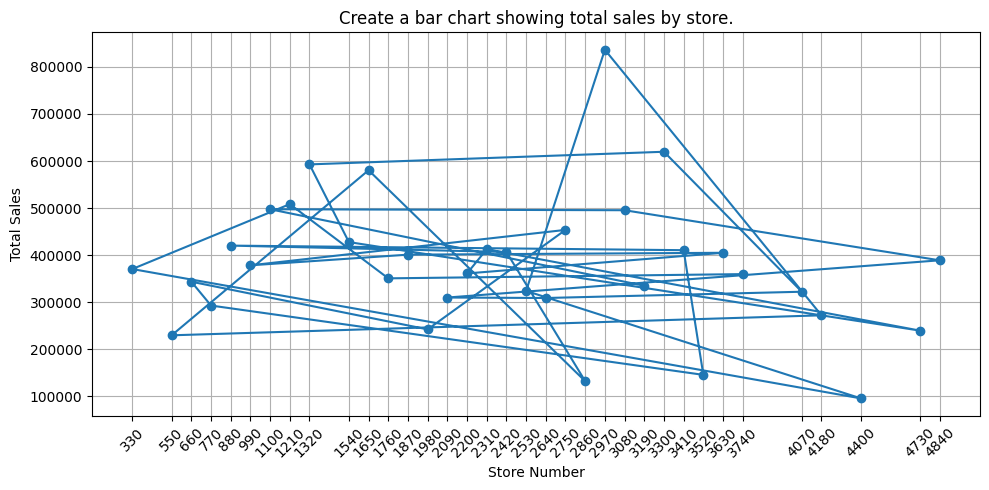

In [14]:
code_gen_df["label"] = code_gen_df["generated_code"].apply(code_is_runnable).map({True: "runnable", False: "not_runnable"})
code_gen_df["score"] = code_gen_df["label"].map({"runnable": 1, "not_runnable": 0})


In [15]:
code_gen_df.head()

,generated_code,label,score
context.span_id,,,
b855f2c0c2a8e136,import pandas as pd\nimport matplotlib.pyplot ...,runnable,1


In [16]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="Runnable Code Eval", dataframe=code_gen_df),
)

In [17]:
CLARITY_LLM_JUDGE_PROMPT = """
In this task, you will be presented with a query and an answer. Your objective is to evaluate the clarity 
of the answer in addressing the query. A clear response is one that is precise, coherent, and directly 
addresses the query without introducing unnecessary complexity or ambiguity. An unclear response is one 
that is vague, disorganized, or difficult to understand, even if it may be factually correct.

Your response should be a single word: either "clear" or "unclear," and it should not include any other 
text or characters. "clear" indicates that the answer is well-structured, easy to understand, and 
appropriately addresses the query. "unclear" indicates that some part of the response could be better 
structured or worded.
Please carefully consider the query and answer before determining your response.

After analyzing the query and the answer, you must write a detailed explanation of your reasoning to 
justify why you chose either "clear" or "unclear." Avoid stating the final label at the beginning of your 
explanation. Your reasoning should include specific points about how the answer does or does not meet the 
criteria for clarity.

[BEGIN DATA]
Query: {query}
Answer: {response}
[END DATA]
Please analyze the data carefully and provide an explanation followed by your response.

EXPLANATION: Provide your reasoning step by step, evaluating the clarity of the answer based on the query.
LABEL: "clear" or "unclear"
"""

In [18]:
query = SpanQuery().where(
    "span_kind=='AGENT'"
).select(
    response="output.value",
    query="input.value"
)

# The Phoenix Client can take this query and return the dataframe.
clarity_df = px.Client().query_spans(query, 
                                     project_name=PROJECT_NAME,
                                     timeout=None)

clarity_df.head()

,response,query
context.span_id,,
c6363e465f3a346a,"The most popular product SKU was 6200700, whic...","[{""role"": ""user"", ""content"": ""What was the mos..."
70acd242c005e166,The total revenue across all stores was approx...,"[{""role"": ""user"", ""content"": ""What was the tot..."
6071bb905ac21285,The store with the highest sales volume is Sto...,"[{""role"": ""user"", ""content"": ""Which store had ..."
9ff9fa66d6141933,Here is the bar chart showing total sales by s...,"[{""role"": ""user"", ""content"": ""Create a bar cha..."
2dfd8079d5ed632e,Approximately 62.56% of items were sold on pro...,"[{""role"": ""user"", ""content"": ""What percentage ..."


In [19]:
with suppress_tracing():
    clarity_eval = llm_classify(
        dataframe = clarity_df,
        template = CLARITY_LLM_JUDGE_PROMPT,
        rails = ['clear', 'unclear'],
        model=OpenAIModel(model="gpt-4o"),
        provide_explanation=True
    )

clarity_eval['score'] = clarity_eval.apply(lambda x: 1 if x['label']=='clear' else 0, axis=1)

clarity_eval.head()

llm_classify |          | 0/6 (0.0%) | ⏳ 00:00<? | ?it/s

,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
c6363e465f3a346a,clear,The query asks for the most popular product SK...,[],COMPLETED,4.802335,1
70acd242c005e166,clear,The query asks for the total revenue across al...,[],COMPLETED,4.942434,1
6071bb905ac21285,clear,The query asks for the store with the highest ...,[],COMPLETED,4.195964,1
9ff9fa66d6141933,clear,The query asks for a bar chart showing total s...,[],COMPLETED,3.911647,1
2dfd8079d5ed632e,clear,The query asks for the percentage of items sol...,[],COMPLETED,4.599451,1


In [20]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="Response Clarity", dataframe=clarity_eval),
)

In [21]:
SQL_EVAL_GEN_PROMPT = """
SQL Evaluation Prompt:
-----------------------
You are tasked with determining if the SQL generated appropiately answers a given instruction
taking into account its generated query and response.

Data:
-----
- [Instruction]: {question}
  This section contains the specific task or problem that the sql query is intended to solve.

- [Reference Query]: {query_gen}
  This is the sql query submitted for evaluation. Analyze it in the context of the provided
  instruction.

Evaluation:
-----------
Your response should be a single word: either "correct" or "incorrect".
You must assume that the db exists and that columns are appropiately named.
You must take into account the response as additional information to determine the correctness.

- "correct" indicates that the sql query correctly solves the instruction.
- "incorrect" indicates that the sql query correctly does not solve the instruction correctly.

Note: Your response should contain only the word "correct" or "incorrect" with no additional text
or characters.
"""

In [22]:
query = SpanQuery().where(
    "span_kind=='LLM'"
).select(
    query_gen="llm.output_messages",
    question="input.value",
)

# The Phoenix Client can take this query and return the dataframe.
sql_df = px.Client().query_spans(query, 
                                 project_name=PROJECT_NAME,
                                 timeout=None)
sql_df = sql_df[sql_df["question"].str.contains("Generate an SQL query based on a prompt.", na=False)]

sql_df.head()

,query_gen,question
context.span_id,,
69050c5291199e15,"[{'message': {'role': 'assistant', 'content': ...","{""messages"": [{""role"": ""user"", ""content"": ""\nG..."
08cb51b5493b3f87,"[{'message': {'role': 'assistant', 'content': ...","{""messages"": [{""role"": ""user"", ""content"": ""\nG..."
6c4a12ce7a498c0e,"[{'message': {'role': 'assistant', 'content': ...","{""messages"": [{""role"": ""user"", ""content"": ""\nG..."
721a8b5eeeee293b,"[{'message': {'role': 'assistant', 'content': ...","{""messages"": [{""role"": ""user"", ""content"": ""\nG..."
827752d3e41b67a6,"[{'message': {'role': 'assistant', 'content': ...","{""messages"": [{""role"": ""user"", ""content"": ""\nG..."


In [23]:
with suppress_tracing():
    sql_gen_eval = llm_classify(
        dataframe = sql_df,
        template = SQL_EVAL_GEN_PROMPT,
        rails = ['correct', 'incorrect'],
        model=OpenAIModel(model="gpt-4o"),
        provide_explanation=True
    )

sql_gen_eval['score'] = sql_gen_eval.apply(lambda x: 1 if x['label']=='correct' else 0, axis=1)

sql_gen_eval.head()

llm_classify |          | 0/6 (0.0%) | ⏳ 00:00<? | ?it/s

,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
69050c5291199e15,correct,The task is to find the most popular product S...,[],COMPLETED,3.569910,1
08cb51b5493b3f87,correct,The SQL query provided is `SELECT SUM(Total_Sa...,[],COMPLETED,3.078330,1
6c4a12ce7a498c0e,correct,The SQL query correctly identifies the store w...,[],COMPLETED,5.160587,1
721a8b5eeeee293b,correct,The SQL query provided correctly calculates th...,[],COMPLETED,5.726428,1
827752d3e41b67a6,correct,The SQL query calculates the percentage of ite...,[],COMPLETED,8.025766,1


In [24]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="SQL Gen Eval", dataframe=sql_gen_eval),
)